# FYS-2021: Exercise set 3: Logistic Regression and Evaluation Metrics

## Task 1)


The sigmoid function for multiple features and multiple samples

In [45]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import axes3d

# def sigmoid(w, X) :
def sigmoid(z) :
    # z = X  @ w.transpose()
    return 1/(1+np.exp(-z))


### 1a) 
Five bivariate instances for each of the two normal distributions. Plotting the instances in the cartesian plane (2d)

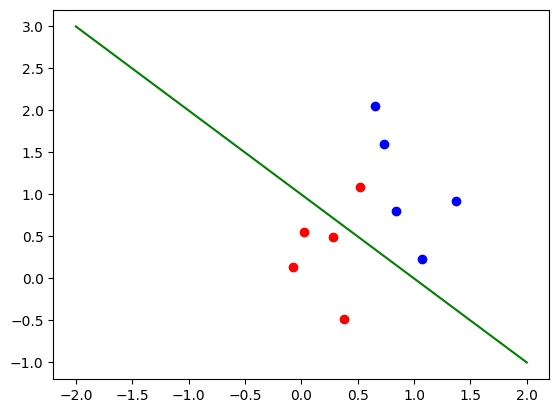

In [46]:
N_1 = multivariate_normal([0,0], cov=0.2)
N_2 = multivariate_normal([1,1], cov=0.2)

X_1 = N_1.rvs(5)
X_2 = N_2.rvs(5)

plt.scatter(X_1[:,0], X_1[:,1], color="red")
plt.scatter(X_2[:,0], X_2[:,1], color="blue")
x =np.linspace(-2,2, 50)
y = 1 - x    # Optimum regression line
plt.plot(x,y, color="green")


### 1b)
Transform the cartesian plane into a 3-d surface where the output of the sigmoid function is depicted on the z-axis

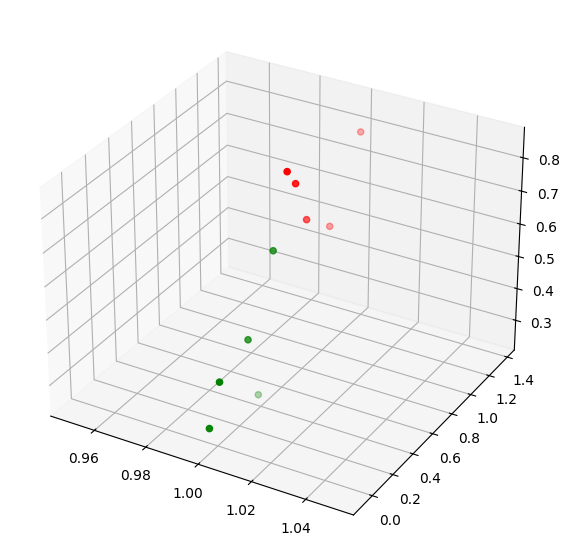

In [47]:
bias = np.ones((5,1))
X_1 = np.hstack((bias, X_1))
X_2 = np.hstack((bias, X_2))

# Suggested parameters for decision boundary. Here w[0] is the constant w_0
w = np.array([-1, 1, 1])

z_1 = sigmoid(X_1 @ w.T)
z_2 = sigmoid(X_2 @ w.T)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(X_1[:,0], X_1[:,1], z_1, color = "green")
ax.scatter(X_2[:,0], X_2[:,1], z_2, color = "red")

plt.show()


### 2a)
Implement vectorized version of logistic gradient descent

In [48]:
def gradient_descent(X: np.ndarray, y: np.ndarray) :

    # X will need the bias column as the first column
    N, d = X.shape  # N samples in d-1 features
    # w = np.random.randn(d,1)   # The + 1 is due to the bias...
    w = np.random.Generator.standard_normal(d)   
    numIter = 0  # Inital number of iterations
    eta = 0.5    # Learning rate
    prev_error = 0
    total_error = 1
    tolerance = 0.0000001
    training_errors = []
    while abs(total_error - prev_error) > tolerance :
        prev_error = total_error
        z = X @ w
        h = sigmoid(z)
        grad = (X.T @ (h - y))/N   # Gradients. Need to transpose X so it will fit the matrix multiplication.
        w = w - eta*grad
        total_error = (np.sqrt((h - y).T @ (h - y)/N))
        numIter += 1
        training_errors.append(total_error.item())
        # print (total_error)

    return w, numIter, training_errors

### 2b)
Test the code with the tictac_end.csv 

In [ ]:
def predict(w, X):
    probabilities = sigmoid(np.dot(X, w))
    return (probabilities >= 0.5).astype(int)

data = pd.read_csv('data/tictac-end.csv', skiprows=7, delimiter=' ')
data = data.sample(frac=1.0, replace=False)
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:,0].to_numpy()

N, d = X.shape
endTrain = int(N*0.7)
X_train = X[:endTrain,:]
X_test = X[endTrain+1:,:]

y = np.reshape(y,(N,1))
y_train = y[:endTrain,:]
y_test = y[endTrain+1:,:]

bias = np.ones((endTrain,1))
X_train = np.concatenate((bias, X_train), axis=1)  # Added the extra column with ones

w, epochs, errors = gradient_descent(X_train, y_train)
print("Number of epochs until convergence: ", epochs)


# Make predictions on the test set
bias = np.ones((X_test.shape[0],1))
X_test = np.concatenate((bias,X_test), axis=1)

y_pred = predict(w, X_test)

# Calculate accuracy on the test set
accuracy = np.mean(y_pred == y_test)
print("Accuracy on the test set:", accuracy)

y_pred = predict(w, X_train)
print("Accuracy on the training set:", np.mean(y_pred == y_train))

plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error vs. Epochs')
plt.show()

### 4a)
Find the true positive and false positive rates

In [ ]:
# Need to program a bit on this one....

### 5a)

1


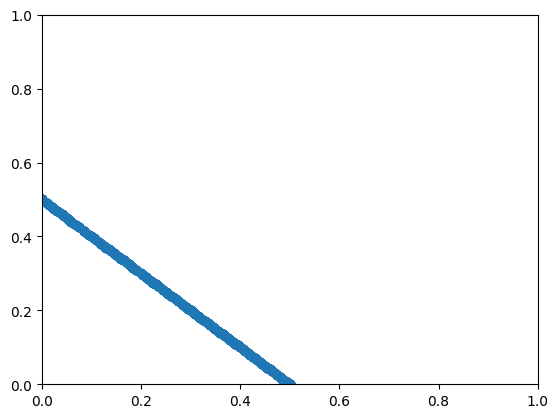

In [55]:
import pandas as pd

df_1 = pd.read_csv("data/soft-classifications-1.csv", delimiter=" ", comment="#")
df_2 = pd.read_csv("data/soft-classifications-2.csv", delimiter=" ", header=None)
df_3 = pd.read_csv("data/soft-classifications-3.csv", delimiter=" ", header=None)

gt = df_2[0]
prob = df_2[1]

print(len(prob[prob>0.999]))


def tp_fp_rates(ground_truth, probabilities, theta):
    negatives_probs = probabilities[ground_truth==0]  # Pick out the real negatives
    positives_probs = probabilities[ground_truth==1]
    n = len(negatives_probs); p = len(positives_probs)
    tp = len(positives_probs[positives_probs>=theta])
    fp = len(positives_probs[positives_probs<theta])

    return tp/p, fp/n

thetas = np.arange(0,1,0.001)
tp = []
fp = []
for theta in thetas:
    returns = tp_fp_rates(gt, prob, theta)
    tp.append(returns[0])
    fp.append(returns[1])

plt.ylim(0,1)
plt.xlim(0,1)
plt.scatter(fp,tp)